In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os.path


from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

This was done using : https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

## Get a balanced sample of 5 songs per genre

In [3]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, num_topics)]
label_lookup = {
    0: "Country",
    1: "Electronic",
    2: "Folk",
    3: "Hip-Hop",
    4: "Indie",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "R&B",
    9: "Rock"
}

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000, random_state=42).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...
1,Country,I'd rather live a life of lies and fantasy Tha...
2,Country,Well I'm making out my list For ole St.Nick to...
3,Country,Though you've gone away I play your favorite s...
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac..."
5,Country,SANTA HO HO HO HO HO hohohohohohoho And what d...
6,Country,In a tiny town where the biggest things Were t...
7,Country,"(I sit here and look at you, lonely room it's ..."
8,Country,I've got this sensitive condition It's aggriva...
9,Country,"I'm traveling down this lonesome road, oh, how..."


## Data Preprocessing

In [5]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())
song_data_processed

,Genre,Lyrics
0,Country,goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...
2,Country,well making list st.nick tonight afraid what w...
3,Country,though gone away play your favorite song blue ...
4,Country,"daddy little girl writers bobby burke, horace ..."
...,...,...
9995,Rock,said couldn find anyone love said there more l...
9996,Rock,caress inside bones caress inside bones house ...
9997,Rock,married fever hotter than pepper sprout been t...
9998,Rock,open your eyes life time flies open light back...


In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# tokenization
song_data_processed['Tokens'] = song_data_processed['Lyrics'].apply(lambda x: x.split())

# remove stop-words
song_data_processed['Tokens'] = song_data_processed['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(song_data_processed)):
    t = ' '.join(song_data_processed['Tokens'][i])
    detokenized_doc.append(t)

song_data_processed['CleanLyrics'] = detokenized_doc
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics
0,Country,goin girl writer bobby bond goin girl summerti...,"[goin, girl, writer, bobby, bond, goin, girl, ...",goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...,"[rather, live, life, lies, fantasy, face, trut...",rather live life lies fantasy face truth reali...
2,Country,well making list st.nick tonight afraid what w...,"[well, making, list, st.nick, tonight, afraid,...",well making list st.nick tonight afraid want y...
3,Country,though gone away play your favorite song blue ...,"[though, gone, away, play, favorite, song, blu...",though gone away play favorite song blue gold ...
4,Country,"daddy little girl writers bobby burke, horace ...","[daddy, little, girl, writers, bobby, burke,, ...","daddy little girl writers bobby burke, horace ..."
...,...,...,...,...
9995,Rock,said couldn find anyone love said there more l...,"[said, find, anyone, love, said, life, broken,...",said find anyone love said life broken heart c...
9996,Rock,caress inside bones caress inside bones house ...,"[caress, inside, bones, caress, inside, bones,...",caress inside bones caress inside bones house ...
9997,Rock,married fever hotter than pepper sprout been t...,"[married, fever, hotter, pepper, sprout, talki...",married fever hotter pepper sprout talkin bout...
9998,Rock,open your eyes life time flies open light back...,"[open, eyes, life, time, flies, open, light, b...",open eyes life time flies open light back open...


## Document-Term Matrix

In [30]:
vectorizer = TfidfVectorizer(stop_words=stop_words, 
                             max_df = 0.05,
                             min_df= 0.01 ,
                             smooth_idf=True)

X = vectorizer.fit_transform(song_data_processed['CleanLyrics'])

X.shape # check shape of the document-term matrix

(10000, 804)

### Topic Modeling

In [31]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=num_topics, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)

TruncatedSVD(n_components=10, n_iter=100, random_state=122)

In [32]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ", end='')
    for t in sorted_terms:
        print(t[0], end=' ')
    print('')

Topic 0: niggas bitch lord lonely verse heaven sometimes nobody dance arms 
Topic 1: niggas bitch bitches verse fuckin hoes hook gettin fucking pussy 
Topic 2: lord heaven jesus niggas born angels glory father pray king 
Topic 3: lord dance woman alright nobody sometimes somebody honey else ready 
Topic 4: dance heaven lonely christmas arms music moon stars happy miss 
Topic 5: dance music blood rock death ready round floor feet shake 
Topic 6: beautiful woman heaven sometimes beauty music repeat today fine playing 
Topic 7: christmas happy snow year white ring woman children bright tree 
Topic 8: heaven nobody woman knows alright else somebody sometimes loving fine 
Topic 9: lonely sometimes round wind wonder alright niggas stars water road 


### Append Topics to DF

In [12]:
X_topics = svd_model.fit_transform(X)
doc_top_df = pd.DataFrame(X_topics, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data, doc_top_df, left_index=True, right_index=True)
#Evaluate most dominant Topics
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...,0.164830,0.033368,0.016255,0.119752,0.157317,-0.154448,-0.028696,-0.034841,-0.066916,0.089207,0
1,Country,I'd rather live a life of lies and fantasy Tha...,0.157017,-0.031952,-0.068358,-0.011679,-0.035090,0.012109,0.002903,0.031495,-0.037782,0.021568,0
2,Country,Well I'm making out my list For ole St.Nick to...,0.301447,0.448223,0.139684,0.096173,-0.038236,0.189707,0.430535,0.053418,0.090684,-0.099790,1
3,Country,Though you've gone away I play your favorite s...,0.131536,-0.029768,-0.059324,-0.031209,0.019241,0.012639,0.014199,0.032219,0.023664,0.014602,0
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac...",0.164786,0.082106,0.007106,0.119243,0.342004,-0.262780,-0.029783,-0.131586,0.026232,-0.077346,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,You said you couldn't find\nAnyone to love ya\...,0.212562,0.044641,-0.039936,-0.008306,0.024033,-0.017472,-0.037879,0.078972,-0.013605,-0.035331,0
9996,Rock,Caress inside my bones\nCaress inside my bones...,0.127796,-0.015845,-0.093020,-0.048805,-0.002449,0.013087,0.006107,0.028934,0.063855,-0.000540,0
9997,Rock,We got married in a fever\nHotter than a peppe...,0.172336,-0.011911,0.032526,0.036575,0.121699,0.171604,-0.068498,-0.044138,-0.017700,-0.016273,0
9998,Rock,Open up your eyes\nSee how life time flies\nOp...,0.096275,-0.008465,0.024499,-0.018561,0.005205,-0.018082,0.016814,-0.022191,-0.013668,-0.028567,0


### Explore Results

#### Crosstab

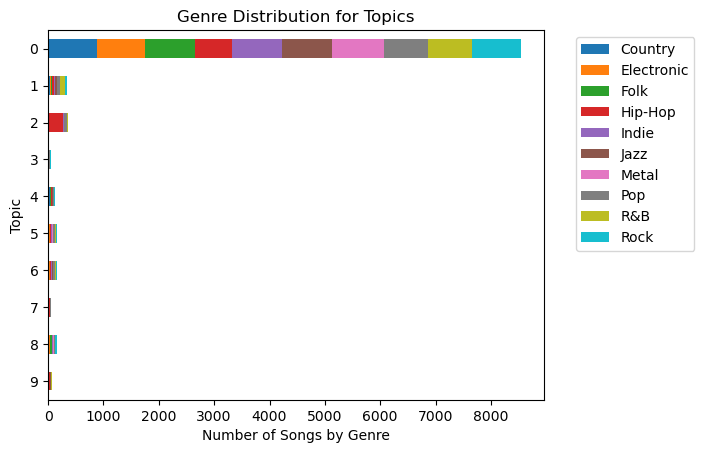

In [13]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

In [14]:
crosstab

Genre,Country,Electronic,Folk,Hip-Hop,Indie,Jazz,Metal,Pop,R&B,Rock
Dominant_Topic,,,,,,,,,,
9,9,8,6,2,3,17,9,2,5,7
8,14,24,28,6,11,11,7,16,13,21
7,8,11,3,3,7,7,3,1,8,2
6,5,28,8,14,17,14,9,27,17,17
5,21,15,6,9,17,7,15,30,22,24
4,26,15,17,4,13,7,2,14,10,19
3,1,3,1,12,2,1,3,8,6,7
2,0,7,1,268,5,1,8,59,6,0
1,26,28,20,25,17,37,7,46,103,35


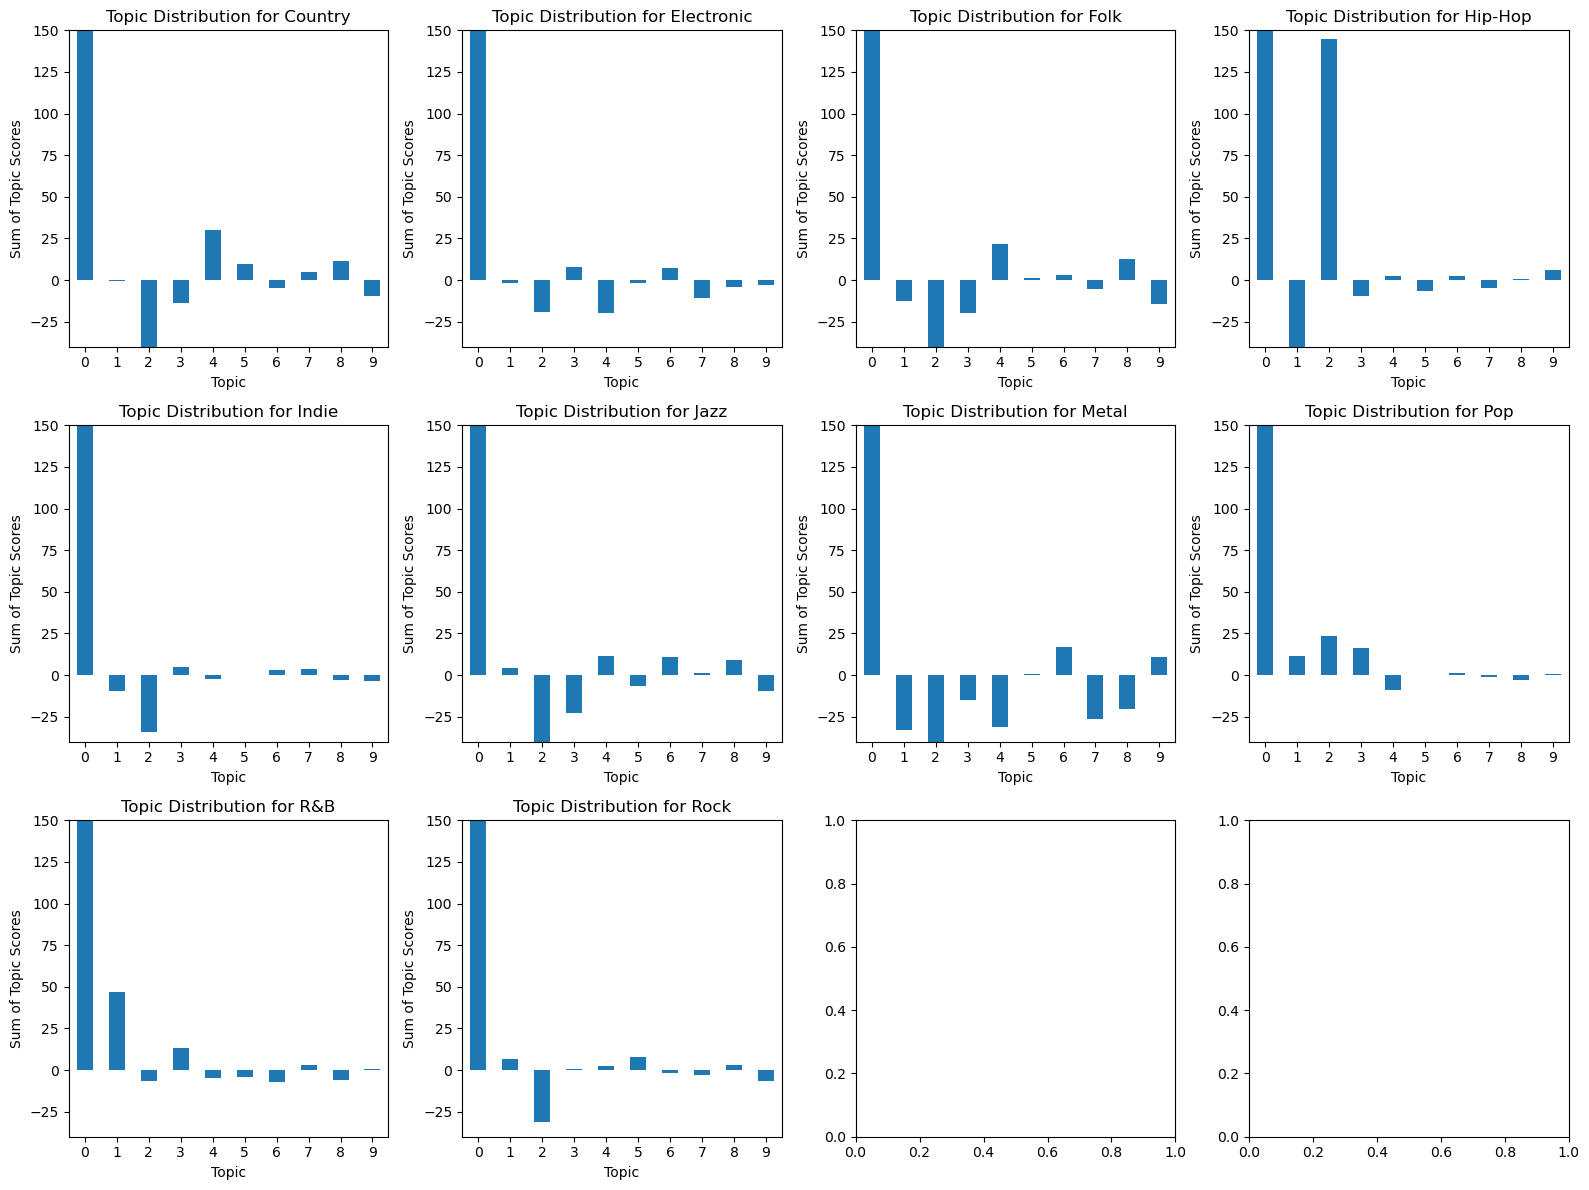

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))  # 3 rows, 4 columns

for i, genre in enumerate(genres):
    row = i // 4  # Row index
    col = i % 4   # Column index
    
    # Plotting
    results[results['Genre'] == genre][topic_columns].sum(axis=0).plot(kind='bar', ax=axs[row, col])
    axs[row, col].set_title(f'Topic Distribution for {genre}')
    axs[row, col].set_xlabel('Topic')
    axs[row, col].set_ylabel('Sum of Topic Scores')
    axs[row, col].tick_params(axis='x', rotation=0)  # Rotate x-labels for better readability
    axs[row][col].set_ylim(-40, 150)  # Set y-axis limit
    

plt.tight_layout()
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

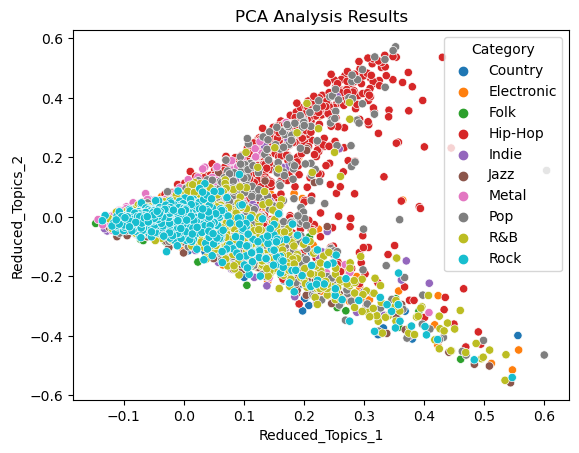

In [16]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

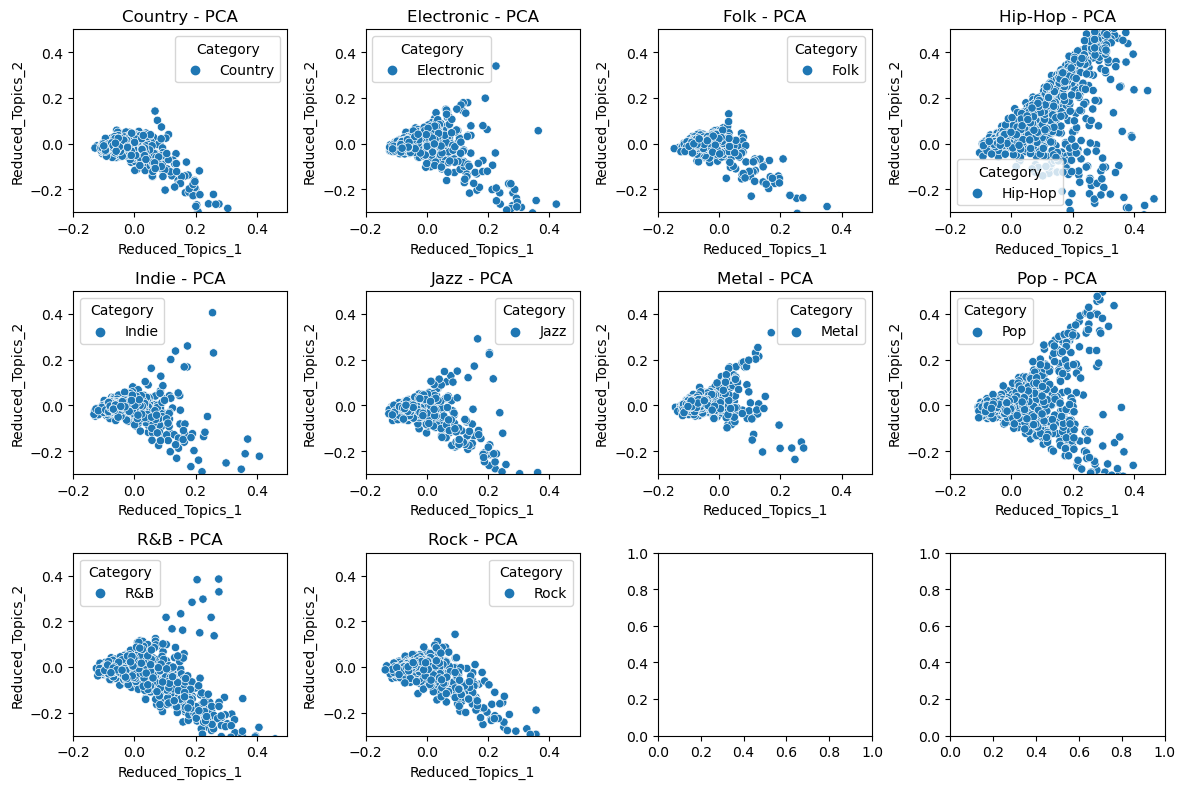

In [17]:
# Create the subplot figure
fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# Iterate over genres and create scatter plots in each subplot
for i, genre in enumerate(genres):
    row = i // 4
    col = i % 4
    sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results[results['Genre'] == genre], ax=axs[row][col])
    axs[row][col].set_title(f'{genre} - PCA')
    axs[row][col].legend(title='Category')
    axs[row][col].set_xlim(-0.2, 0.5)  # Set x-axis limit
    axs[row][col].set_ylim(-0.3, 0.5)  # Set y-axis limit

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

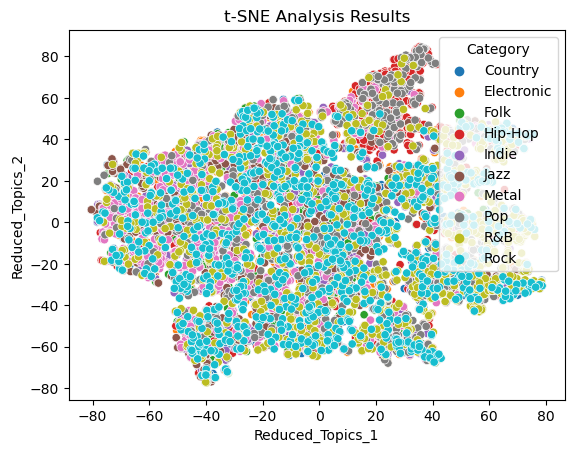

In [18]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
reduced = tsne.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced

#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('t-SNE Analysis Results')
plt.legend(title='Category')
plt.show()

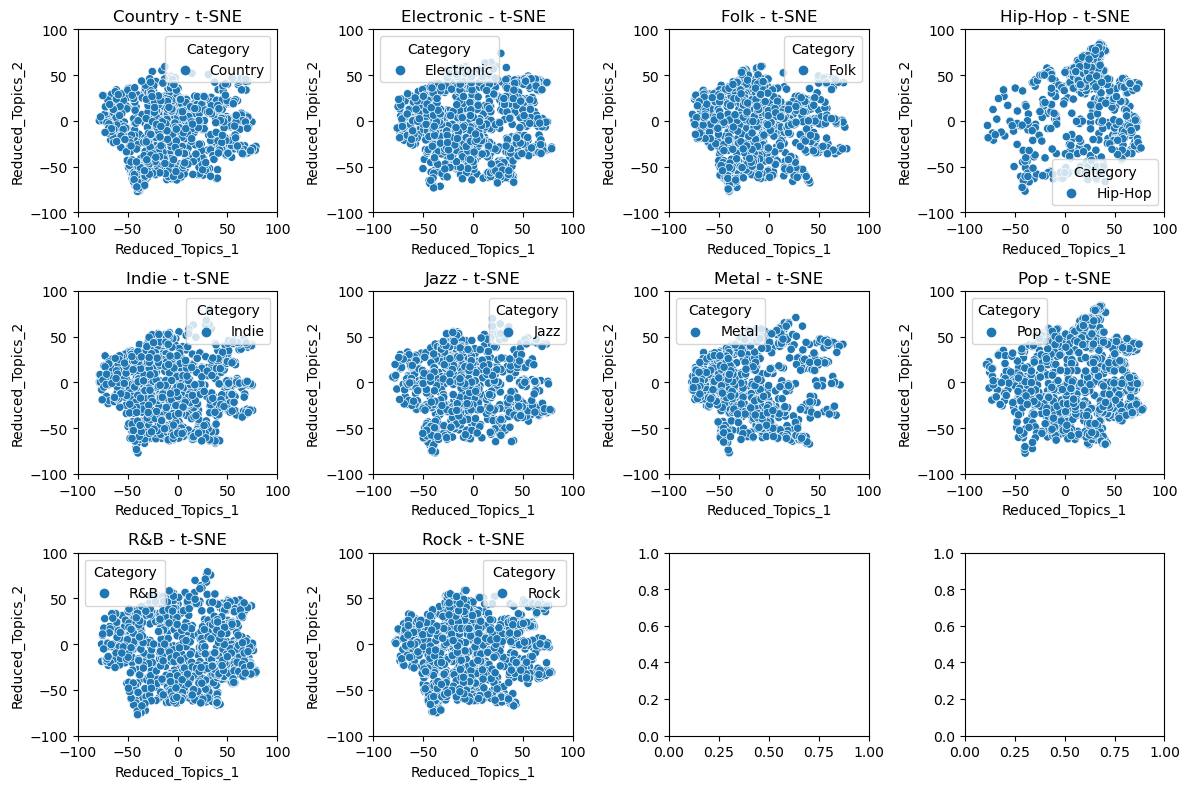

In [19]:
# Create the subplot figure
fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# Iterate over genres and create scatter plots in each subplot
for i, genre in enumerate(genres):
    row = i // 4
    col = i % 4
    sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results[results['Genre'] == genre], ax=axs[row][col])
    axs[row][col].set_title(f'{genre} - t-SNE')
    axs[row][col].legend(title='Category')
    axs[row][col].set_xlim(-100, 100)  # Set x-axis limit
    axs[row][col].set_ylim(-100, 100)  # Set y-axis limit

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Using Clustering

In [20]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...,0.164830,0.033368,0.016255,0.119752,0.157317,-0.154448,-0.028696,-0.034841,-0.066916,0.089207,0,64.445396,0.254290,2
1,Country,I'd rather live a life of lies and fantasy Tha...,0.157017,-0.031952,-0.068358,-0.011679,-0.035090,0.012109,0.002903,0.031495,-0.037782,0.021568,0,-17.830935,-32.097191,0
2,Country,Well I'm making out my list For ole St.Nick to...,0.301447,0.448223,0.139684,0.096173,-0.038236,0.189707,0.430535,0.053418,0.090684,-0.099790,1,68.570457,33.630989,8
3,Country,Though you've gone away I play your favorite s...,0.131536,-0.029768,-0.059324,-0.031209,0.019241,0.012639,0.014199,0.032219,0.023664,0.014602,0,-2.536204,-5.535119,7
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac...",0.164786,0.082106,0.007106,0.119243,0.342004,-0.262780,-0.029783,-0.131586,0.026232,-0.077346,4,69.022522,2.575818,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,You said you couldn't find\nAnyone to love ya\...,0.212562,0.044641,-0.039936,-0.008306,0.024033,-0.017472,-0.037879,0.078972,-0.013605,-0.035331,0,20.941914,-14.268933,0
9996,Rock,Caress inside my bones\nCaress inside my bones...,0.127796,-0.015845,-0.093020,-0.048805,-0.002449,0.013087,0.006107,0.028934,0.063855,-0.000540,0,-31.882393,-43.993282,7
9997,Rock,We got married in a fever\nHotter than a peppe...,0.172336,-0.011911,0.032526,0.036575,0.121699,0.171604,-0.068498,-0.044138,-0.017700,-0.016273,0,39.651901,21.199589,9
9998,Rock,Open up your eyes\nSee how life time flies\nOp...,0.096275,-0.008465,0.024499,-0.018561,0.005205,-0.018082,0.016814,-0.022191,-0.013668,-0.028567,0,-16.678732,51.996567,7


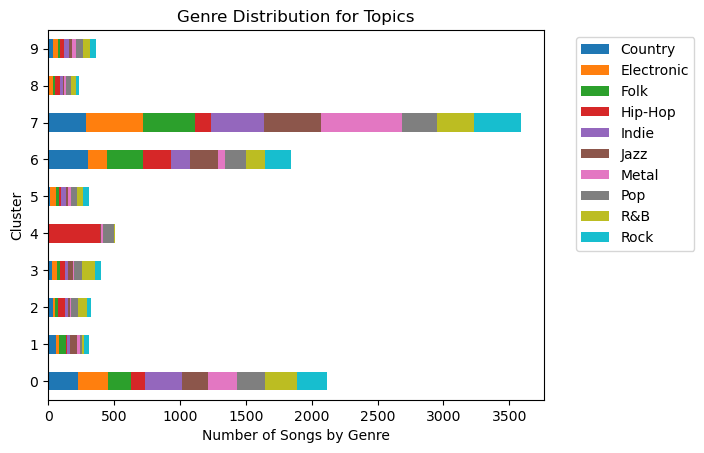

In [21]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

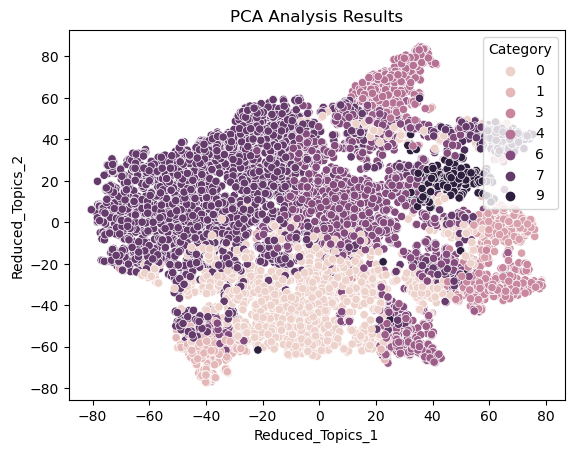

In [22]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [23]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [24]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.24033333333333334

In [25]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.26066666666666666

In [26]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.27166666666666667

### Get Classification Matrix (of knn)

In [27]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.25      0.15      0.19       318
           1       0.19      0.27      0.22       308
           2       0.21      0.27      0.24       288
           3       0.67      0.61      0.64       303
           4       0.15      0.06      0.08       320
           5       0.24      0.33      0.28       290
           6       0.26      0.59      0.36       292
           7       0.20      0.09      0.13       292
           8       0.28      0.14      0.19       324
           9       0.11      0.11      0.11       265

    accuracy                           0.26      3000
   macro avg       0.26      0.26      0.24      3000
weighted avg       0.26      0.26      0.24      3000



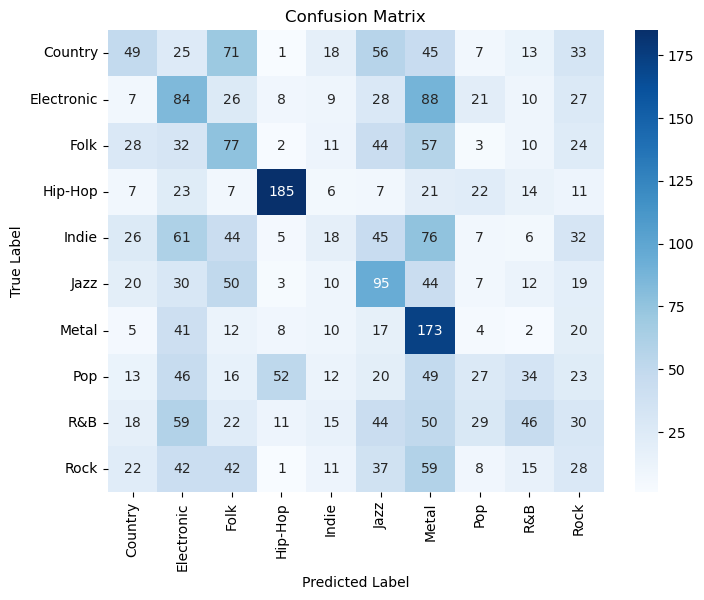

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = np.array([label_lookup.get(i) for i in svc.classes_])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LSA on the songs (aka Document-Term Matrix + SVD)
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 

### Ergebnis
- Teils Zusammenhang zwischen prominenten Topics und Song Genres
- Vor Allem HipHop Topics fallen auffallend oft in die gleiche Kategorie
- Ergebnisse eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics nach wie vor nur schlecht möglich, aber nochmal besser als bei der LDA
- Einige Genres wie Folk und Pop sind extrem schwer vorherzusagen, was wohl bedeutet dass hier die Themenbereiche am wenigsten eingeschränkt sind
- Auf dem zweiten Platz ist Metall und Jazz, welche auch relativ gut vorhergesagt wird
- Die ergebnisse scheinen allerdings weniger eindeutig zu sein als bei der LDA
- LSI performed bei manchen genres extrem schlecht und bei manchen sehr gut
- Ergebnisse sind abhängig von max-df parameter und der anzahl der terms
- Topic 0 taucht komischerweise extrem oft auf. Das ist weil der erste Singular Vektor die größte Importance hat für die Approximierung der Term Document matrix
- Viele Wörter tauchen mehrmals auf in verschiedenen topics

### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.